In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os 
os.getcwd()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.simplefilter(action="ignore", category=ConvergenceWarning)

In [5]:
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate

In [6]:
# !pip install xgboost 

In [7]:
#Read the dataset

In [8]:
data=pd.read_excel('dataset\ENB2012_data.xlsx')
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


# Pre-processing

Renaming columns with a actual name

In [9]:
parameters= """relative compactness,surface area,wall area,roof area,overall height,orientation,glazing area,glazing area distribution,heating load,cooling load"""
parameters=parameters.replace(' ','_')
parameters=parameters.split(",")

x=data.columns.tolist()
parameters

['relative_compactness',
 'surface_area',
 'wall_area',
 'roof_area',
 'overall_height',
 'orientation',
 'glazing_area',
 'glazing_area_distribution',
 'heating_load',
 'cooling_load']

Create a dictionary to map the names 

In [10]:
col={}
for i , j in zip(x,parameters):
#     print(i,j)
    col[i]=j
    
print(col)
data.rename(columns=col,inplace=True)
data.head()

{'X1': 'relative_compactness', 'X2': 'surface_area', 'X3': 'wall_area', 'X4': 'roof_area', 'X5': 'overall_height', 'X6': 'orientation', 'X7': 'glazing_area', 'X8': 'glazing_area_distribution', 'Y1': 'heating_load', 'Y2': 'cooling_load'}


,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [11]:
data.to_csv("dataset/label_data.csv", index=False)

Handling Missing values and outliers

In [12]:
data.isnull().sum() #no null values

relative_compactness         0
surface_area                 0
wall_area                    0
roof_area                    0
overall_height               0
orientation                  0
glazing_area                 0
glazing_area_distribution    0
heating_load                 0
cooling_load                 0
dtype: int64

In [13]:
def detect_outliers_zscore(data, threshold=3):
    z_scores = np.abs((data - data.mean(axis=0)) / data.std(axis=0))
    return np.where(z_scores > threshold)

detect_outliers_zscore(data)

# No outliers

(array([], dtype=int64), array([], dtype=int64))

In [14]:
data["wall_area"]+data['roof_area']*2+data['glazing_area']

0      514.5
1      514.5
2      514.5
3      514.5
4      563.5
       ...  
763    784.4
764    808.9
765    808.9
766    808.9
767    808.9
Length: 768, dtype: float64

In [15]:
data['surface_area']

0      514.5
1      514.5
2      514.5
3      514.5
4      563.5
       ...  
763    784.0
764    808.5
765    808.5
766    808.5
767    808.5
Name: surface_area, Length: 768, dtype: float64

### Outlier Detection

In [16]:
def outlier_thresholds(dataframe,col_name,q1=0.10,q3=0.90):
  quartile1 = dataframe[col_name].quantile(q1)
  quartile3 = dataframe[col_name].quantile(q3)
  interquartile_range = quartile3 - quartile1
  low_limit = quartile1 - 1.5 * interquartile_range
  up_limit = quartile3 + 1.5 * interquartile_range
  return low_limit,up_limit


def check_outlier(dataframe, col_name):
  low_limit,up_limit = outlier_thresholds(dataframe,col_name)
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
    return True
  else:
    return False
def replace_with_thresholds(dataframe, col_name):
  low_limit, up_limit = outlier_thresholds(dataframe, col_name)
  dataframe.loc[(dataframe[col_name] < low_limit), col_name] = low_limit
  dataframe.loc[(dataframe[col_name] > up_limit), col_name] = up_limit

def solve_outliers(dataframe, target=None):
    
    cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
    print("\tOutliers Detection")
    for col in num_cols:
        if True:
#       if col==target:
          print(col," - " check_outlier(dataframe, col))
          if check_outlier(dataframe, col):
            replace_with_thresholds(dataframe, col)
        
        
def grab_col_names(dataframe, cat_th=10, car_th=20):
    
    #Catgeorical Variable Selection
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category","object","bool"]]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes in ["uint8","int64","float64"]]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and str(dataframe[col].dtypes) in ["category","object"]]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    #Numerical Variable Selection
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["uint8","int64","float64"]]
#     num_cols = [col for col in num_cols if col not in cat_cols]
    
#     print(cat_cols, num_cols, cat_but_car, num_but_cat)
    return cat_cols, num_cols, cat_but_car, num_but_cat


solve_outliers(data)

	Outliers Detection
relative_compactness False
surface_area False
wall_area False
roof_area False
overall_height False
orientation False
glazing_area False
glazing_area_distribution False
heating_load False
cooling_load False


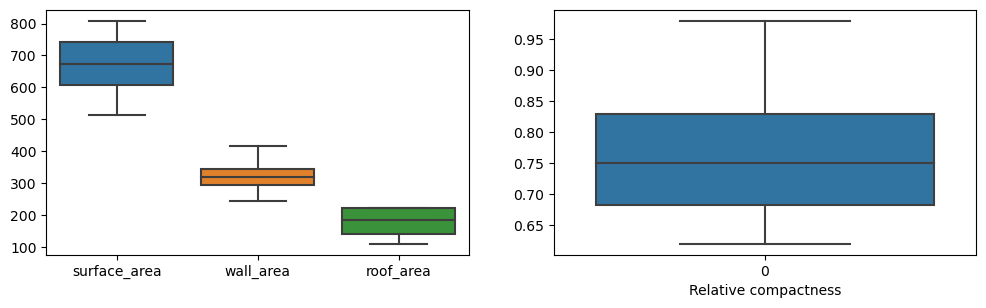

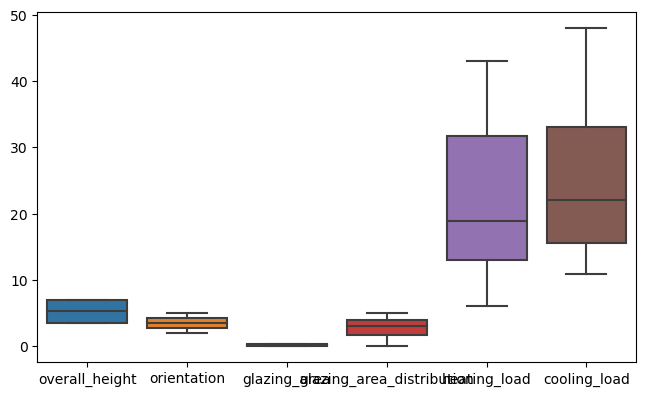

In [17]:
plt.figure(figsize=(12,7))
plt.subplot(2,2,1);

sns.boxplot(data=data[parameters[1:4]])

plt.subplot(2,2,2)

plt.xlabel('Relative compactness')
sns.boxplot(data=data[parameters[0]])

plt.figure(figsize=(17,10))
plt.subplot(2,2,3)
sns.boxplot(data=data[parameters[4:]])

plt.show()

# EDA

In [18]:
def shape_(data):
    print("Rows: ", data.shape[0])
    print("Columns: ", data.shape[1])
shape_(data)

Rows:  768
Columns:  10


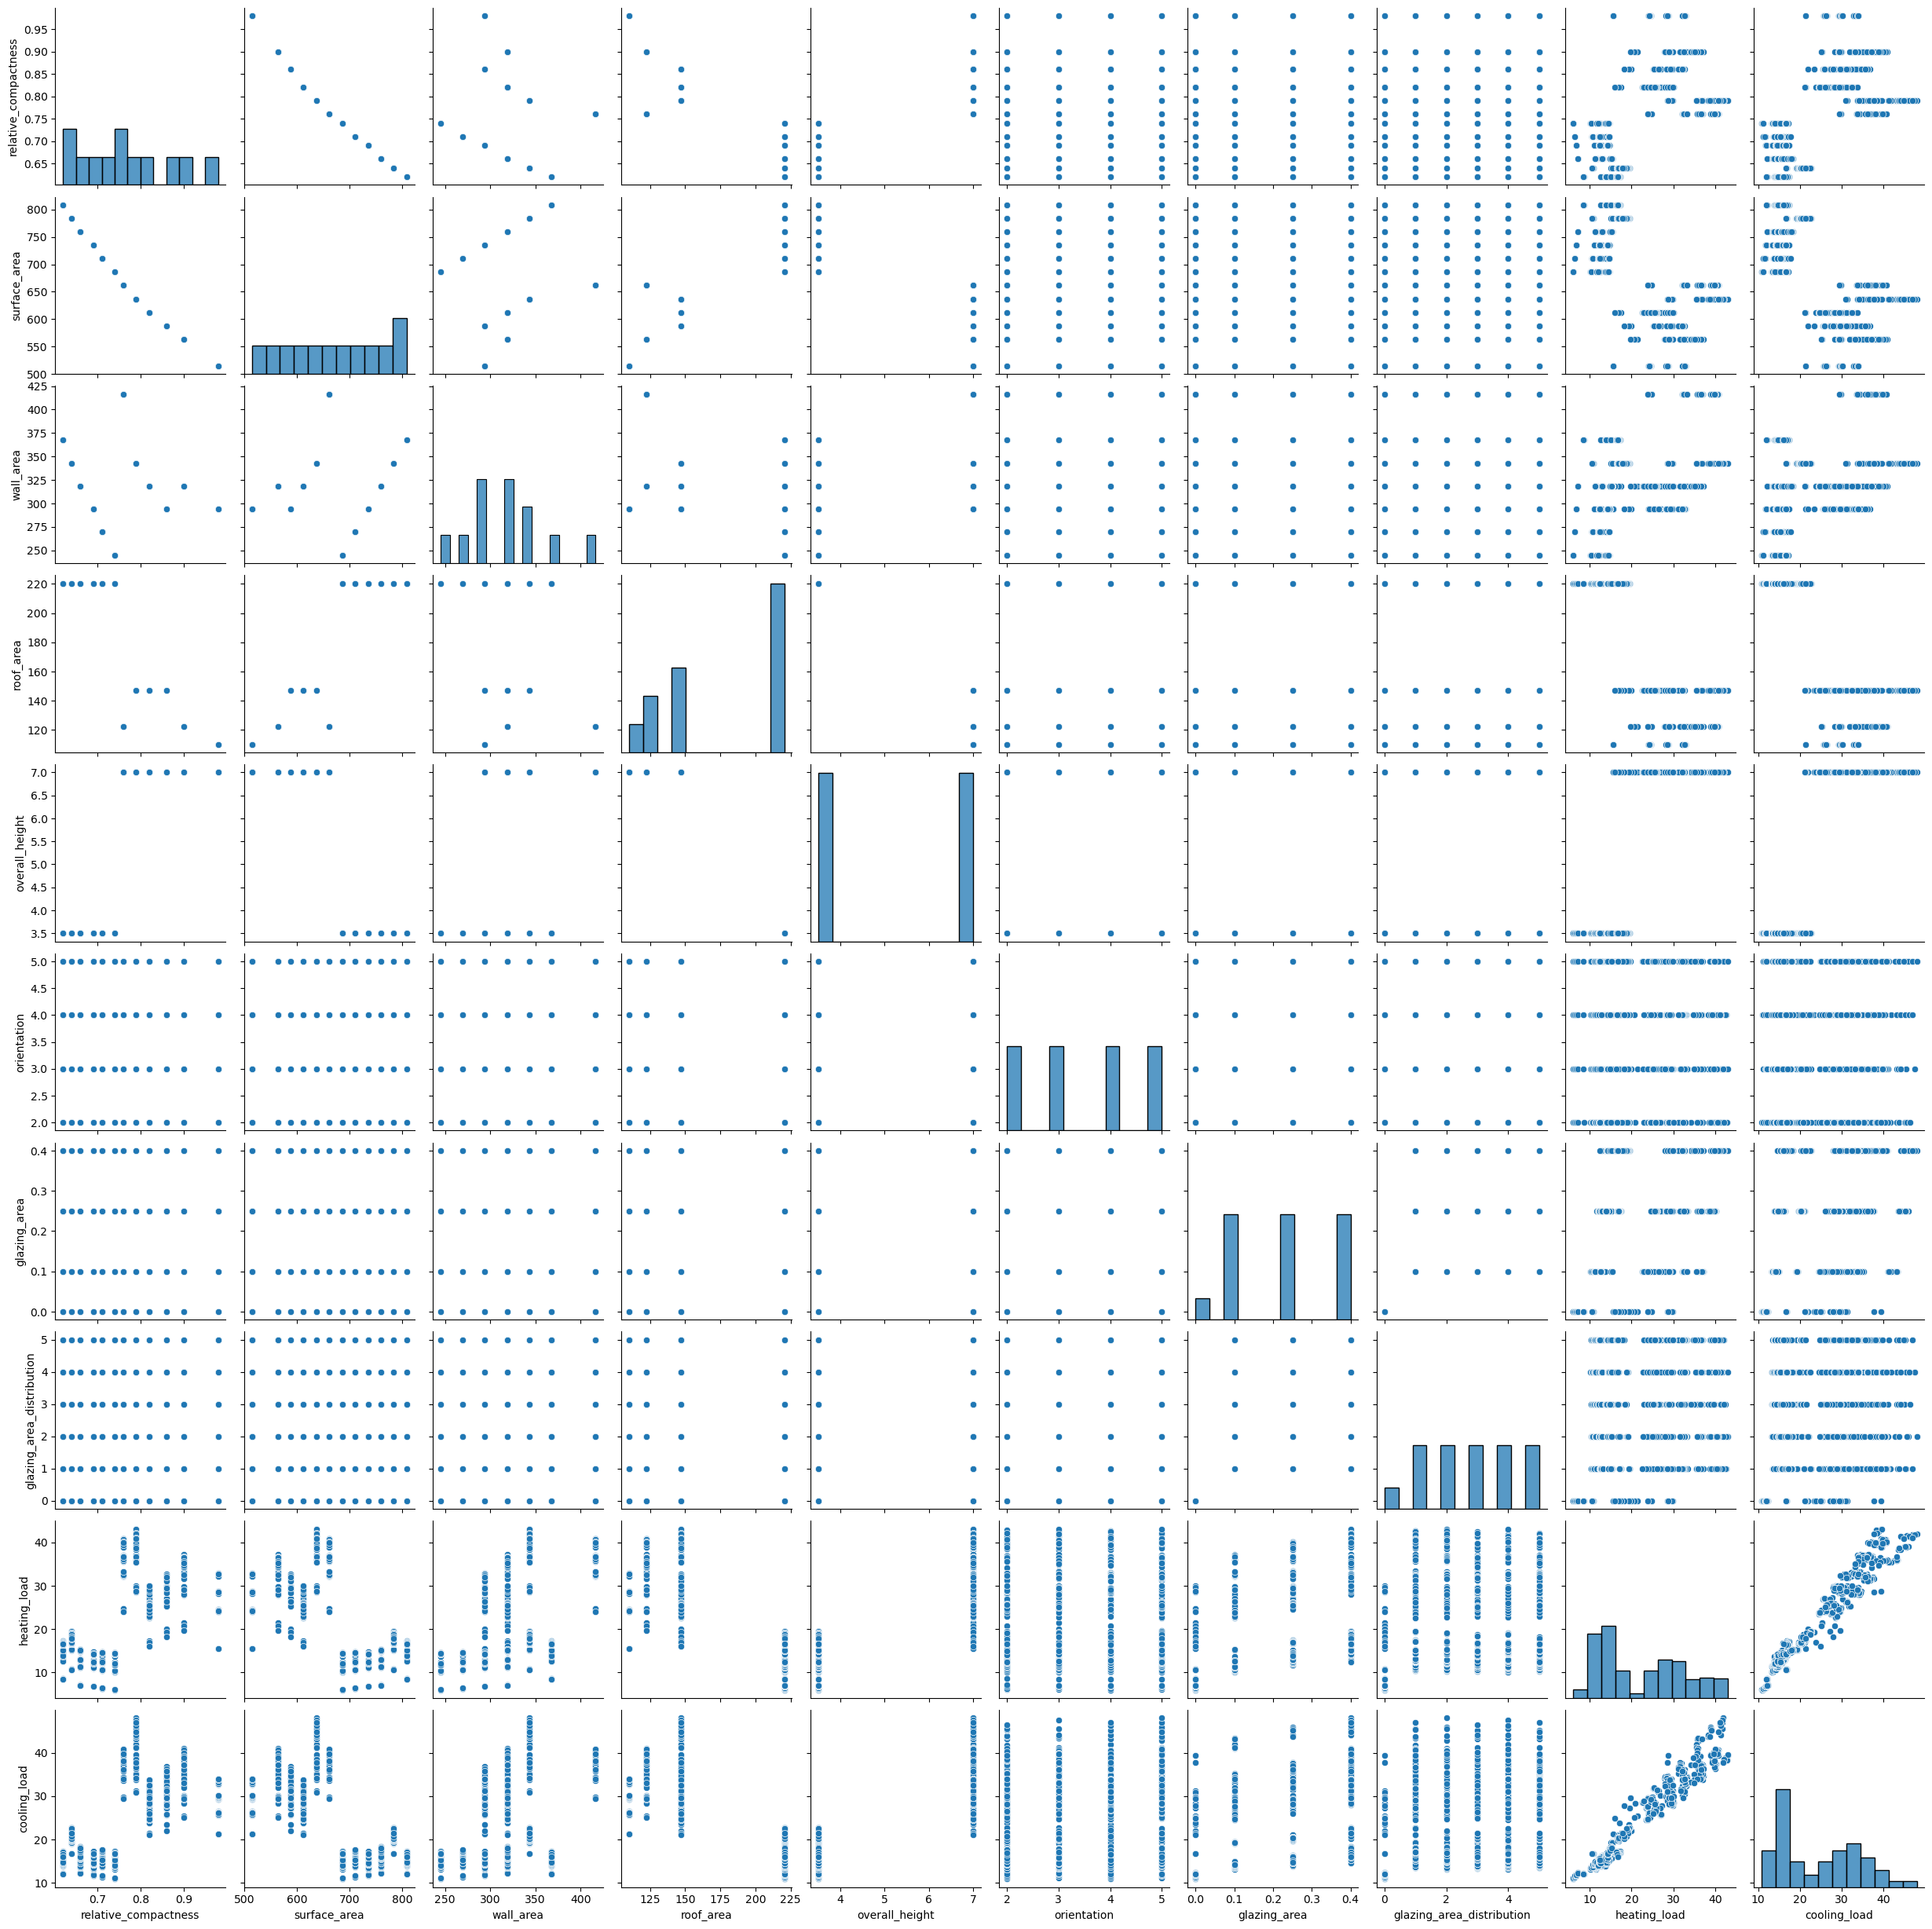

In [21]:
sns.pairplot(data[parameters]);

In [ ]:
def check_df(dataframe,head=5):

    print(f"{'Head':*^50}\n")
    print(dataframe.head(head))
    print(shape_(dataframe))
    
    print(f"{'Data Types':*^50}\n")
    print(dataframe.dtypes)
    

    print(f"{'NULL Values':*^50}\n")
    print(dataframe.isnull().sum())
    

    print(f"{'Describe':*^50}\n")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
check_df(data,2)

In [ ]:
data.describe()

In [ ]:
data.info()

In [ ]:
data.nunique()

In [ ]:
data['surface_area'].value_counts()

In [ ]:
data[parameters[:5]].value_counts()

In [ ]:
plt.figure(figsize=(12,7))
plt.subplot(2,2,1)
plt.title("Histplot")
sns.histplot(data['Y2'], bins=20,color='green');
sns.histplot(data['Y1'], bins=20,color='red');
plt.subplot(2,2,2)
plt.title("Density plot")
data.Y2.plot.kde(color='green') ;
data.Y1.plot.kde(color='red') ;

Top corelated values

In [ ]:
sns.heatmap(data.corr(),annot=True,fmt='.2f');

In [ ]:
class corr_:
    def __init__(self,data:pd.DataFrame):
        self.data=data
        self.corr=data.corr


    def corr_1vsall(self,target:str):
        column=data.columns.tolist()
        corr=data.corr()[target]
#         print(f"\t{target} vs Other Parameters")
        print(f"{target+' vs Other Parameters ':*^50}\n")
        print(corr.sort_values(ascending=False)*100,'\n')
        
    def corr_1vs1(self,x:str,y:str):
        corr= data[x].corr(data[y])
        print(f"{x} vs {y}")
        print(corr*100)



c=corr_(data)
# c.corr_1vsall('Y1')
# c.corr_1vs1('Y1','Y2')

In [ ]:
corr=data[parameters] .corr()
matrix=np.triu(np.ones_like(corr),1)==1
corr=corr.where(matrix).stack()
highcorrelatedvalues=corr.nsmallest() #.abs()
print(f"{'Top negatively Correlated value pairs':*^50}\n")
print(highcorrelatedvalues*100)
corr=highcorrelatedvalues
# a=corr.to_frame()
# a

In [ ]:
corr=data[parameters] .corr()
matrix=np.triu(np.ones_like(corr),1)==1
corr=corr.where(matrix).stack()
highcorrelatedvalues=corr.nlargest() #.abs()
print(f"{'Top postively Correlated value pairs':*^50}\n")
print(highcorrelatedvalues*100)
corr=highcorrelatedvalues
# a=corr.to_frame()
# a

### Insight from the graph
Relative compactness and surface area are strong negative corelated with each other

surface area and wall area are partially postively corelated 

relative compactness and wall area are partially correlated



### Insight from calculation
surface_area        and  roof_area                    88.071952

relative_compactness and  overall_height               82.774732

relative_compactness  and surface_area     -99.190146

roof_area           and   overall_height   -97.251224

relative_compactness and  roof_area        -86.882341

surface_area         and  overall_height   -85.814767


### Visualization

In [ ]:
sns.pairplot(data[parameters[:4]]);

In [ ]:

def count_plot(data):
    
    index=data.nunique().index.tolist()
    
    value=data.nunique().values.tolist()
    
    d=cvt_dict(index,value)
    l=len(d)
    i=1
    plt.figure(figsize=(12,9))
    for x in d.keys():
        
        count_(x,data,i)
        i+=1
def count_(x,data,i):
    plt.figure(figsize=(14,9))
    plt.subplot(4,2,i)
    sns.countplot(x=x,data=data);
    plt.tight_layout()
    plt.show();
    
def cvt_dict(l1:list,l2:list):
    d={}
    for i ,j in zip(l1,l2):
        d[i]=j
    return d

count_plot(data[parameters])


# Model Building

In [ ]:
def create_base_model(dataframe, target, plot=False, save_results=False):
  names = []
  train_rmse_results = []
  test_rmse_results = []
  train_r2_scores = []
  test_r2_scores = []
  X = dataframe.drop(target, axis=1)
  y = dataframe[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)
  models = [('LR', LinearRegression()),
            ("Ridge", Ridge()),
            ("Lasso", Lasso()),
            ("ElasticNet", ElasticNet()),
            ('KNN', KNeighborsRegressor()),
            ('CART', DecisionTreeRegressor()),
            ('RF', RandomForestRegressor()),
            ("XGBoost", XGBRegressor(objective='reg:squarederror'))]

  
  print(f"{'Model Results':*^50}")

  for name, regressor in models:
    regressor.fit(X_train, y_train)
    y_train_pred = regressor.predict(X_train)
    y_test_pred = regressor.predict(X_test)
    # RMSE
    train_rmse_result = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse_result = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_rmse_results.append(train_rmse_result)
    test_rmse_results.append(test_rmse_result)
    # score
    train_r2_score = regressor.score(X_train, y_train)
    test_r2_score = regressor.score(X_test, y_test)
    train_r2_scores.append(train_r2_score)
    test_r2_scores.append(test_r2_score)
    names.append(name)
  
  model_results = pd.DataFrame({'Model_Names': names,
                                'RMSE_Train': train_rmse_results,
                                'RMSE_Test': test_rmse_results,
                                'R2_score_Train': train_r2_scores,
                                'R2_score_Test': test_r2_scores
                                }).set_index("Model_Names")
  model_results=model_results.sort_values(by="RMSE_Test", ascending=True)
  print(model_results)

  if plot:
    plt.figure(figsize=(15, 7))
    sns.barplot(x='RMSE_Test', y=model_results.index, data=model_results, color="r")
    plt.xlabel('RMSE Values')
    plt.ylabel('Model Names')
    plt.title('RMSE_Test for All Models')
    plt.show()
  
  if save_results:
    model_results.to_csv("models_metrics/model_results.csv")
  
  return model_results
model_results = create_base_model(data, target=["Y1","Y2"], plot=True, save_results=True)


### Fine Tunning

In [ ]:
def create_model_tuned(dataframe, target, plot=True, save_results=True):
  names = []
  train_rmse_results = []
  test_rmse_results = []
  train_r2_scores = []
  test_r2_scores = []
  best_params = []
  X = dataframe.drop(target, axis=1)
  y = dataframe[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

  ridge_params = {"alpha": 10**np.linspace(10,-2,100)*0.5}

  lasso_params = {"alpha": 10**np.linspace(10,-2,100)*0.5}

  enet_params = {"alpha": 10**np.linspace(10,-2,100)*0.5}

  knn_params = {"n_neighbors": np.arange(1,50,1)}

  cart_params = {"min_samples_split": range(2,100),
                  "max_leaf_nodes": range(2,10)}

  xgboost_params = {"colsample_bytree": [0.4, 0.5 ,0.6],
                      "n_estimators": [200, 500, 1000],
                      "max_depth": [3,5,8],
                      "learning_rate": [0.1, 0.01]}

  rf_params = {"max_depth": [5, 8, 15, None],
              "max_features": [5, 7, "auto"],
              "min_samples_split": [8, 15, 20],
              "n_estimators": [200, 500]}

  regressors = [("Ridge", Ridge(), ridge_params),
              ("Lasso", Lasso(), lasso_params),
              ("ENet", ElasticNet(), enet_params),
              ("KNN", KNeighborsRegressor(), knn_params),
              ("CART", DecisionTreeRegressor(), cart_params),
              ("XGBoost", XGBRegressor(objective="reg:squarederror"), xgboost_params),
              ("RF", RandomForestRegressor(), rf_params)]

  for name, regressor, params in regressors:
    print(f"{name:*^25}")

    gs_best = GridSearchCV(regressor, params, cv=3, n_jobs=-1, verbose=False).fit(X_train, y_train)

    final_model = regressor.set_params(**gs_best.best_params_).fit(X_train, y_train)
    train_rmse_result = np.mean(np.sqrt(-cross_val_score(final_model, X_train, y_train, cv=10, scoring="neg_mean_squared_error")))
    test_rmse_result = np.mean(np.sqrt(-cross_val_score(final_model, X_test, y_test, cv=10, scoring="neg_mean_squared_error")))
    train_rmse_results.append(train_rmse_result)
    test_rmse_results.append(test_rmse_result)
    train_r2_score = final_model.score(X_train, y_train)
    test_r2_score = final_model.score(X_test, y_test)
    train_r2_scores.append(train_r2_score)
    test_r2_scores.append(test_r2_score)
    print(f"RMSE_Train: {round(train_rmse_result, 4)} , RMSE_Test: {round(test_rmse_result, 4)} , R2_Train: {round(train_r2_score, 3)} , R2_Test: {round(test_r2_score, 3)} (Tuned Model) ({name}) ")

    print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
    best_params.append(gs_best.best_params_)
    names.append(name)
  
  model_tuned_results = pd.DataFrame({'Model_Names': names,
                                'RMSE_Train': train_rmse_results,
                                'RMSE_Test': test_rmse_results,
                                'R2_score_Train': train_r2_scores,
                                'R2_score_Test': test_r2_scores,
                                "best_params": best_params
                                }).set_index("Model_Names")
  model_tuned_results=model_tuned_results.sort_values(by="RMSE_Test", ascending=True)
  print(model_tuned_results)

  if plot:
    plt.figure(figsize=(15, 12))
    sns.barplot(x='RMSE_Test', y=model_tuned_results.index, data=model_tuned_results, color="r")
    plt.xlabel('RMSE Values')
    plt.ylabel('Model Names')
    plt.title('RMSE_Test for All Models')
    plt.show()
  
  if save_results:
    model_tuned_results.to_csv("models_metrics/model_tuned_results.csv")
  
  return model_tuned_results

In [ ]:
model_tuned_results = create_model_tuned(data, ["heating_load","cooling_load"], plot=True, save_results=True)
